In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.api import VAR
import scipy
import pmdarima as pm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
from warnings import filterwarnings 
warnings.filterwarnings("ignore", category = DeprecationWarning) 
filterwarnings('ignore')

In [2]:
df = pd.read_csv('weatherYerevan.csv')
df['datetime'] = pd.to_datetime(df['datetime'])

In [3]:
df.set_index('datetime', inplace=True)

# Resample the data to weekly means
weekly_means = df.resample('W').mean()
df = weekly_means

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 280 entries, 2018-07-01 to 2023-11-05
Freq: W-SUN
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tempmax           280 non-null    float64
 1   tempmin           280 non-null    float64
 2   temp              280 non-null    float64
 3   feelslikemax      280 non-null    float64
 4   feelslikemin      280 non-null    float64
 5   feelslike         280 non-null    float64
 6   dew               280 non-null    float64
 7   humidity          280 non-null    float64
 8   precip            280 non-null    float64
 9   precipprob        280 non-null    float64
 10  precipcover       280 non-null    float64
 11  snow              280 non-null    float64
 12  snowdepth         280 non-null    float64
 13  windgust          243 non-null    float64
 14  windspeed         280 non-null    float64
 15  winddir           280 non-null    float64
 16  sealevelpress

drop some columns which may be correlated and have na values

In [5]:
df.columns

Index(['tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin',
       'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover',
       'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir',
       'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation',
       'solarenergy', 'uvindex', 'severerisk', 'moonphase'],
      dtype='object')

In [6]:
df.drop(['tempmax', 'tempmin', 'feelslikemax','snow', 'feelslikemin', 'severerisk','feelslike', 'precipprob', 'precipcover', 'solarradiation', 'solarenergy','snowdepth', 'windgust', 'moonphase'], axis=1, inplace=True)
df = df.dropna()

<Axes: >

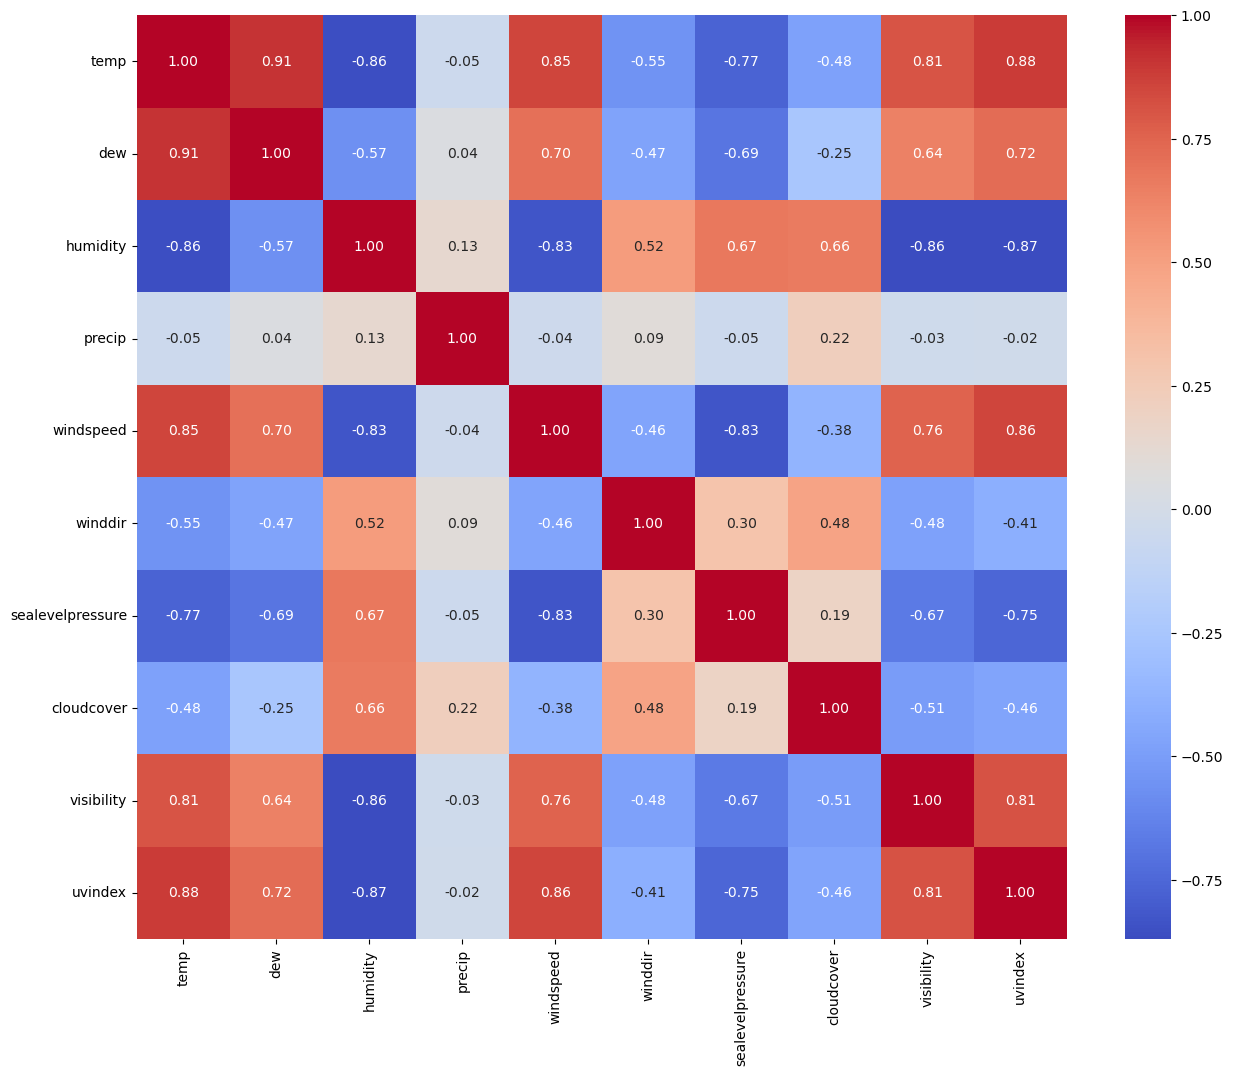

In [7]:
plt.figure(figsize=(15, 12))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

In [8]:
df.head(10)

,temp,dew,humidity,precip,windspeed,winddir,sealevelpressure,cloudcover,visibility,uvindex
datetime,,,,,,,,,,
2018-07-01,30.800000,9.600000,31.500000,0.000000,27.700000,51.800000,1007.300000,0.200000,14.500000,10.000000
2018-07-08,31.185714,9.628571,30.100000,0.000000,28.614286,57.057143,1006.657143,5.557143,14.528571,9.857143
2018-07-15,30.985714,13.685714,37.600000,0.014286,29.285714,107.471429,1005.100000,13.571429,14.400000,10.000000
2018-07-22,26.500000,11.314286,43.214286,0.271429,28.200000,46.771429,1004.771429,13.928571,14.500000,8.714286
2018-07-29,29.785714,12.642857,38.214286,0.142857,31.542857,45.200000,1005.371429,5.900000,13.500000,9.714286
2018-08-05,28.285714,12.185714,41.128571,0.328571,30.528571,79.585714,1006.900000,28.914286,13.957143,9.000000
2018-08-12,27.085714,12.942857,43.857143,0.742857,34.114286,70.642857,1009.142857,10.671429,14.485714,9.571429
2018-08-19,25.985714,10.985714,40.885714,1.240429,31.828571,42.057143,1008.842857,13.271429,14.928571,9.142857
2018-08-26,25.585714,11.700000,44.900000,0.129286,28.814286,47.342857,1011.342857,12.314286,14.885714,8.857143


Temp exhibits strong positive correlations with dew, windspeed, visibility, and UV index, while being negatively correlated with humidity and sealevelpressure. Dew and windspeed also show positive correlations with visibility and UV index. Humidity is negatively correlated with temperature, windspeed, and UV index. Sealevelpressure has a strong negative correlation with windspeed and visibility. Cloud cover has a positive correlation with humidity and visibility but a negative correlation with sealevelpressure. UV index shows positive correlations with temperature, dew, windspeed, and visibility. 

# Target Variable is temp(average temperature)

# SARIMA


• plot the data and comment on existence of seasonality and/or trend

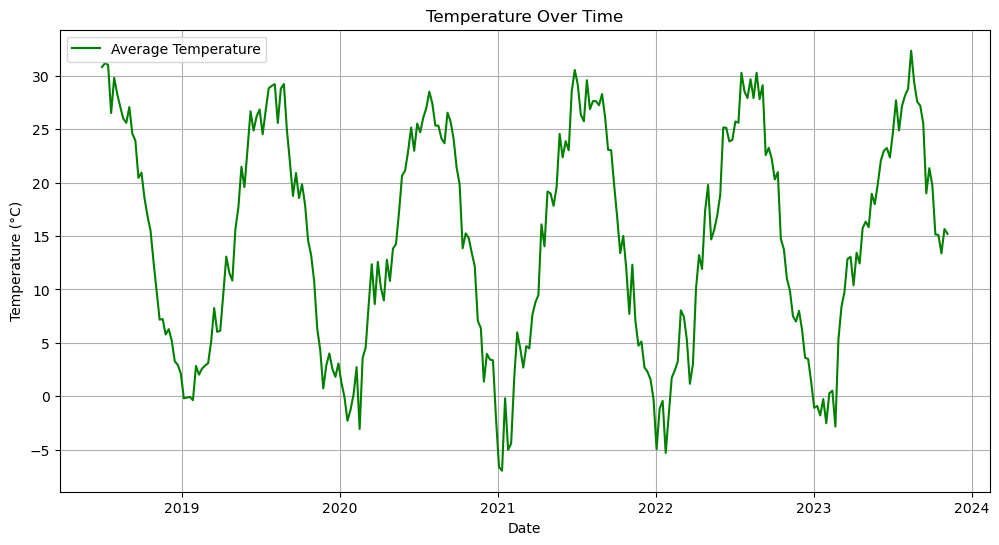

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['temp'], label='Average Temperature', color='green')
plt.title('Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid()
plt.show()

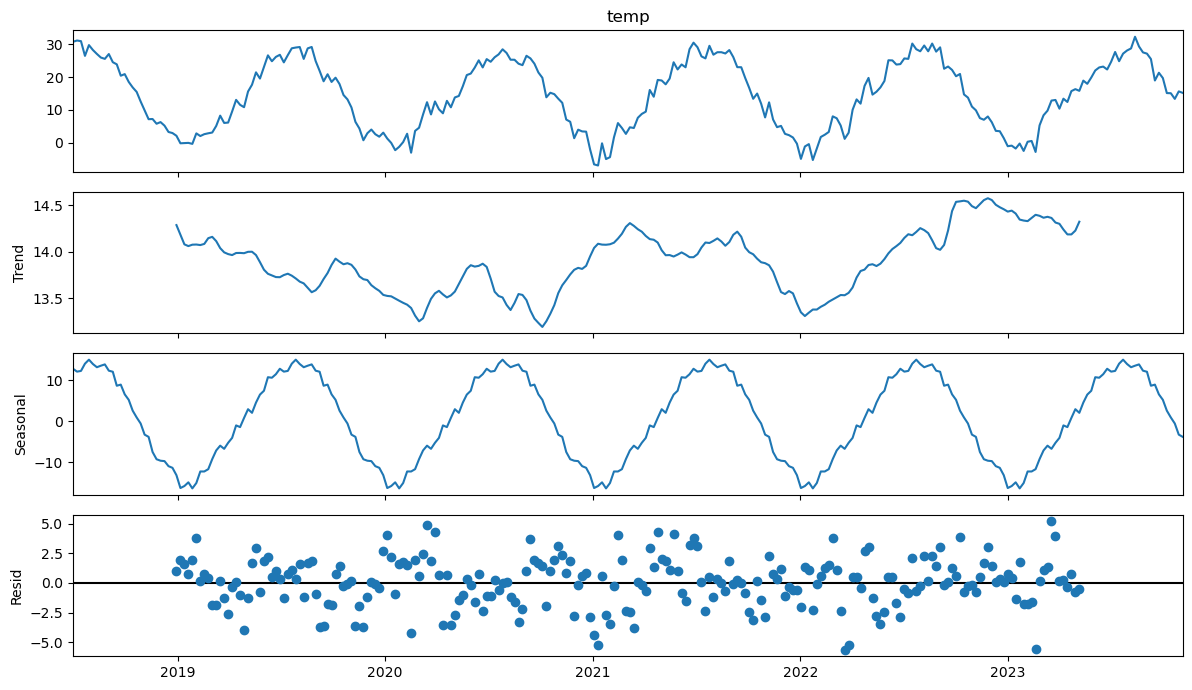

In [10]:
model_add = seasonal_decompose(df['temp'], model='additive',period = 52)
fig = model_add.plot()
fig.set_size_inches((12, 7))
fig.tight_layout()
plt.show()

The model has seasonality, but no trend(it has cyclic trend, but it's not increasing or decreasing).

• transform the data (if necessary), check stationarity (ADF, KPSS, comment)

In [11]:
# ADF Test
adf_result = adfuller(df['temp'])
print("ADF Test Results:")
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print(f'Critical Values: {adf_result[4]}')

# KPSS Test
kpss_result = kpss(df['temp'], regression='c')
print("\nKPSS Test Results:")
print(f'KPSS Statistic: {kpss_result[0]}')
print(f'p-value: {kpss_result[1]}')
print(f'Critical Values: {kpss_result[3]}')

if adf_result[1] < 0.05 and kpss_result[1] > 0.05:
    print('The time series data is stationary based on ADF and KPSS tests.')
elif adf_result[1] >= 0.05 and kpss_result[1] < 0.05:
    print('The time series data is non-stationary based on both ADF and KPSS tests.')
elif adf_result[1] >= 0.05 and kpss_result[1] >= 0.05:
    print('The time series data is non-stationary based on ADF test, but stationary based on KPSS test.')
else:
    print('The time series data is inconclusive for stationarity based on ADF and KPSS tests.')

ADF Test Results:
ADF Statistic: -8.717841913228327
p-value: 3.449447554377337e-14
Critical Values: {'1%': -3.4554613060274972, '5%': -2.8725931472675046, '10%': -2.5726600403359887}

KPSS Test Results:
KPSS Statistic: 0.043941191978516723
p-value: 0.1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
The time series data is stationary based on ADF and KPSS tests.


In [12]:
df.reset_index(inplace = True)

• identify the dependence orders of the model (ACF, PACF diagnostic, comment)

<Figure size 1200x600 with 0 Axes>

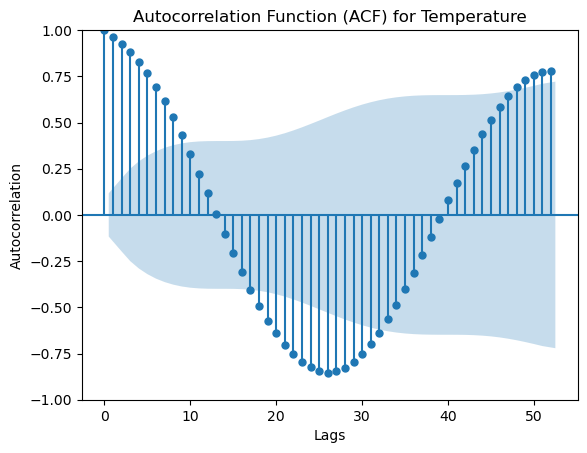

<Figure size 1200x600 with 0 Axes>

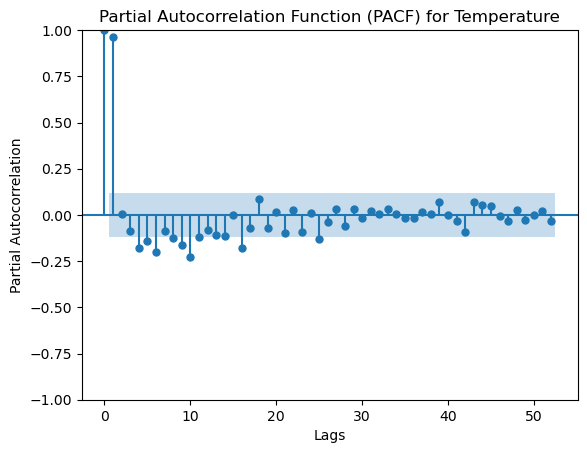

In [13]:
# Plot ACF
plt.figure(figsize=(12, 6))
plot_acf(df["temp"], lags=52, alpha=0.05)
plt.title('Autocorrelation Function (ACF) for Temperature')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

# Plot PACF
plt.figure(figsize=(12, 6))
plot_pacf(df["temp"], lags=52, alpha=0.05)
plt.title('Partial Autocorrelation Function (PACF) for Temperature')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.show()

Data is stationary, In the ACF plot, we see that the series is seasonal, as every 26th lag shows deterministic seasonal pattern. 

In the PACF plot, we see that after the first lag, the other lags are either significant or close to being significant. 

• Divide the data into train and test sets (take the ratio of your choice) estimate the model on
train set

In [14]:
train = int(df.shape[0] * 0.8)  # 80% of data for training
test = df.shape[0] - train  # 20% of data for testing

train_data = df.iloc[:train]
test_data = df.iloc[train:]


In [15]:
sarima = SARIMAX(train_data.temp,order = (26, 0 ,2), seasonal_order = (2,0,3,52))
sarima_fit = sarima.fit()
print(sarima_fit.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           34     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.23215D+00    |proj g|=  7.67071D-02

At iterate    5    f=  2.20731D+00    |proj g|=  2.42395D-02

At iterate   10    f=  2.20465D+00    |proj g|=  3.51498D-03

At iterate   15    f=  2.20451D+00    |proj g|=  3.35151D-03

At iterate   20    f=  2.20427D+00    |proj g|=  6.38597D-03

At iterate   25    f=  2.20323D+00    |proj g|=  1.26523D-02

At iterate   30    f=  2.20194D+00    |proj g|=  1.56653D-02

At iterate   35    f=  2.19806D+00    |proj g|=  1.30317D-02

At iterate   40    f=  2.19391D+00    |proj g|=  2.33623D-02

At iterate   45    f=  2.19023D+00    |proj g|=  2.51975D-02

At iterate   50    f=  2.18609D+00    |proj g|=  3.09985D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

• perform residual diagnostics (including Ljung-Box test, comment)

In [16]:
residuals = sarima_fit.resid

acorr_ljungbox(residuals, return_df = True)

,lb_stat,lb_pvalue
1,0.036672,0.848133
2,0.036806,0.981765
3,0.966830,0.809277
4,1.198095,0.878412
5,1.201425,0.944741
6,1.453096,0.962549
7,1.467490,0.983414
8,1.496333,0.992769
9,1.533664,0.996889
10,2.036355,0.996054


p-values are greater than 0.05, meaning the residuals are iid.

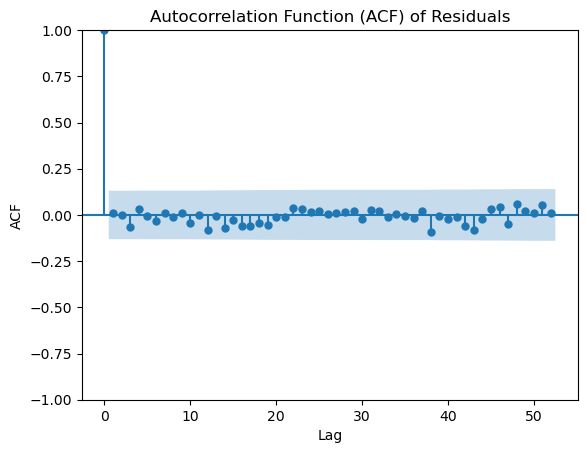

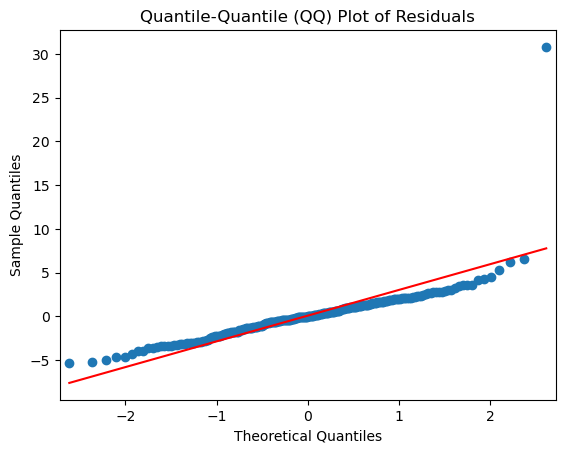

In [17]:
# Autocorrelation Function (ACF)
plot_acf(residuals, lags = 52)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.show()

# Quantile-Quantile (QQ) plot
sm.qqplot(residuals, line = 's')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.title('Quantile-Quantile (QQ) Plot of Residuals')
plt.show()

As we can see from the ACF plot, the model has captured all the relevant patterns in the data.
From QQ plot we observe, the points are on the line, indicating that the residuals are almost normally distributed.

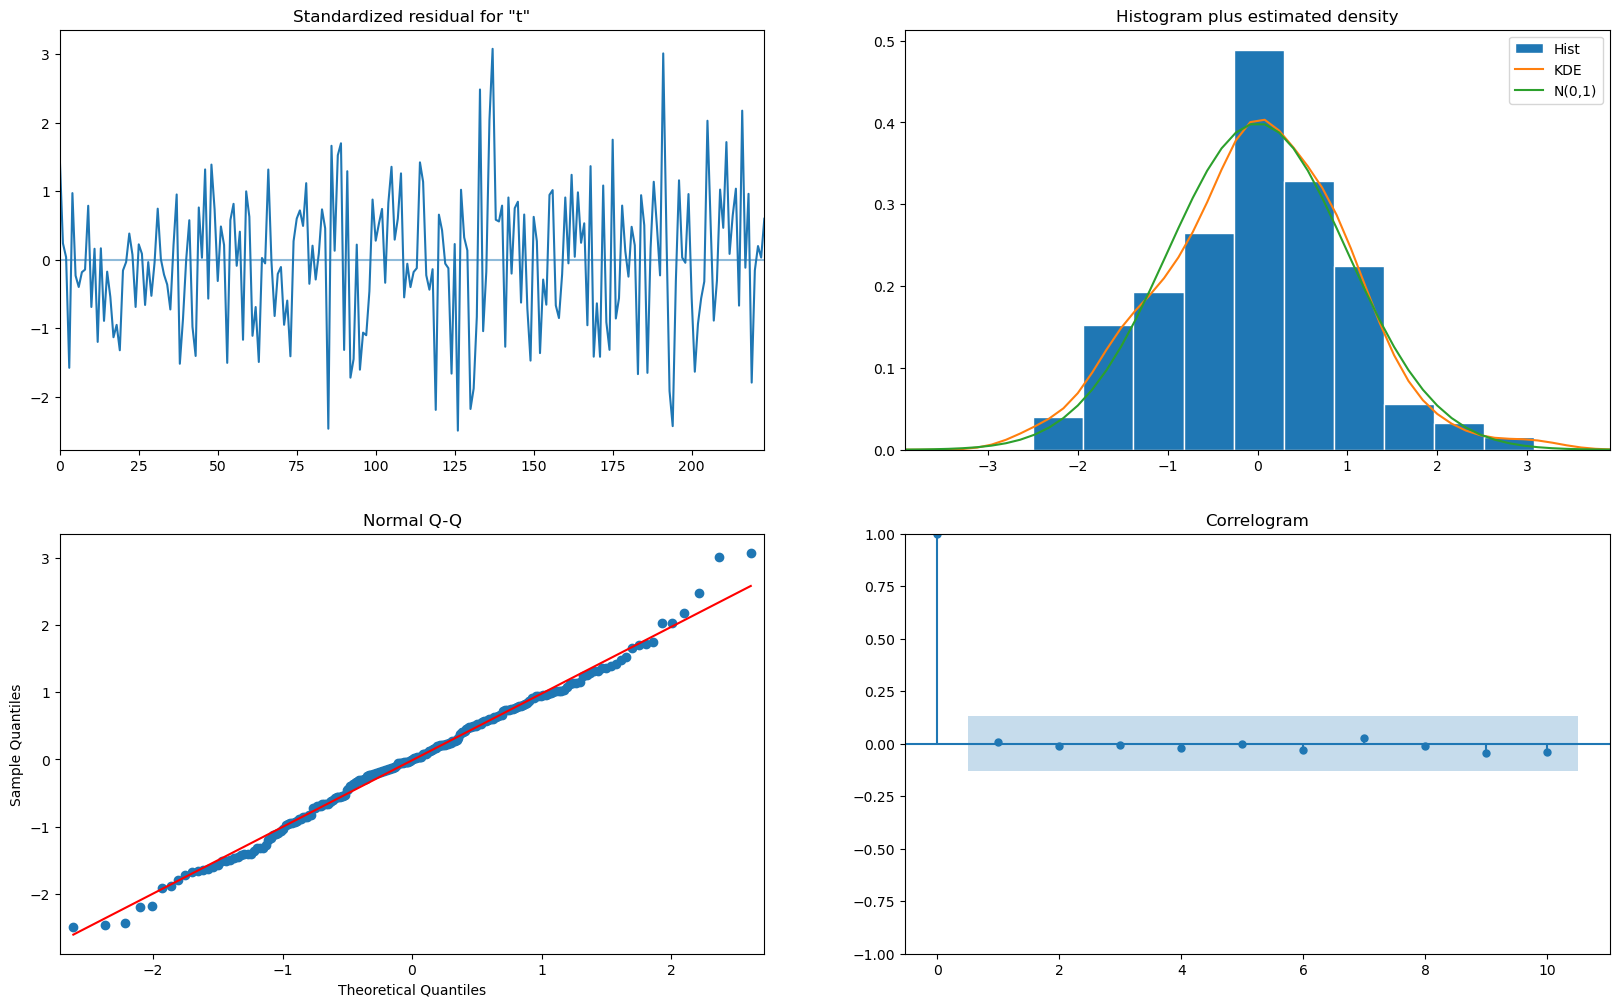

In [18]:
sarima_fit.plot_diagnostics(figsize = (20,12))
plt.show()

• estimate model on train set with auto.arima, do forecast with both models for test set, choose
best model based on minimum Mean Squared Error (if best model is one with auto.arima
comment, e.g. try to understand does it make sense or not)


In [19]:
sarima_auto_arima = pm.auto_arima(train_data.temp, start_p = 1, start_q = 1,
                      test = 'adf', max_p = 7, max_q = 7, m = 26,
                      d = None, seasonal = True, start_P = 0,
                      D = None, trace = True, error_action = 'ignore',
                      suppress_warnings = True, stepwise = True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[26] intercept   : AIC=1076.736, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[26] intercept   : AIC=1693.442, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[26] intercept   : AIC=1070.553, Time=0.30 sec
 ARIMA(0,0,1)(0,0,1)[26] intercept   : AIC=1345.508, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[26]             : AIC=1934.094, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[26] intercept   : AIC=1092.453, Time=0.02 sec
 ARIMA(1,0,0)(2,0,0)[26] intercept   : AIC=1070.089, Time=3.50 sec
 ARIMA(1,0,0)(2,0,1)[26] intercept   : AIC=inf, Time=5.82 sec
 ARIMA(1,0,0)(1,0,1)[26] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(0,0,0)(2,0,0)[26] intercept   : AIC=inf, Time=2.66 sec
 ARIMA(2,0,0)(2,0,0)[26] intercept   : AIC=1069.263, Time=3.98 sec
 ARIMA(2,0,0)(1,0,0)[26] intercept   : AIC=1070.712, Time=0.41 sec
 ARIMA(2,0,0)(2,0,1)[26] intercept   : AIC=inf, Time=6.39 sec
 ARIMA(2,0,0)(1,0,1)[26] intercept   : AIC=inf, Time=0.88 sec
 ARIMA(3,0,0)(2,0,0)[26] intercept   : AIC=1

In [20]:
model_exp = ExponentialSmoothing(train_data['temp'], trend=None, seasonal= 'add',seasonal_periods=52)
model_exp_fit = model_exp.fit()
print(model_exp_fit.summary())


                       ExponentialSmoothing Model Results                       
Dep. Variable:                     temp   No. Observations:                  224
Model:             ExponentialSmoothing   SSE                            906.635
Optimized:                         True   AIC                            421.173
Trend:                             None   BIC                            605.402
Seasonal:                      Additive   AICC                           459.400
Seasonal Periods:                    52   Date:                 Sun, 17 Dec 2023
Box-Cox:                          False   Time:                         21:50:42
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.3259054                alpha                 True
smoothing_seasonal       

## MSE of all models' preds on the train set

In [21]:
train_auto_preds, conf_int = sarima_auto_arima.predict(n_periods=len(train_data), return_conf_int=True)
train_sarima_preds = sarima_fit.forecast(len(train_data.temp))
train_exp_smoothing_preds= model_exp_fit.forecast(len(train_data.temp))

In [22]:
train_sarima_auto_mse = np.sqrt(mean_squared_error(train_data.temp, train_auto_preds))
train_sarima_mse = np.sqrt(mean_squared_error(train_data.temp, train_sarima_preds))
train_exp_mse = np.sqrt(mean_squared_error(train_data.temp, train_exp_smoothing_preds))
print("MSE for SARIMA trained model is ", train_sarima_mse)
print("MSE for Auto SARIMA trained model is ",train_sarima_auto_mse)
print("MSE for Exponential trained Smoothing is ",train_exp_mse)

MSE for SARIMA trained model is  12.821863369995537
MSE for Auto SARIMA trained model is  10.603766162013851
MSE for Exponential trained Smoothing is  17.182115792999927


## Predictions

In [23]:
auto_preds, conf_int = sarima_auto_arima.predict(n_periods=len(test_data), return_conf_int=True)
sarima_preds = sarima_fit.forecast(len(test_data.temp))
exp_smoothing_preds= model_exp_fit.forecast(len(test_data.temp))

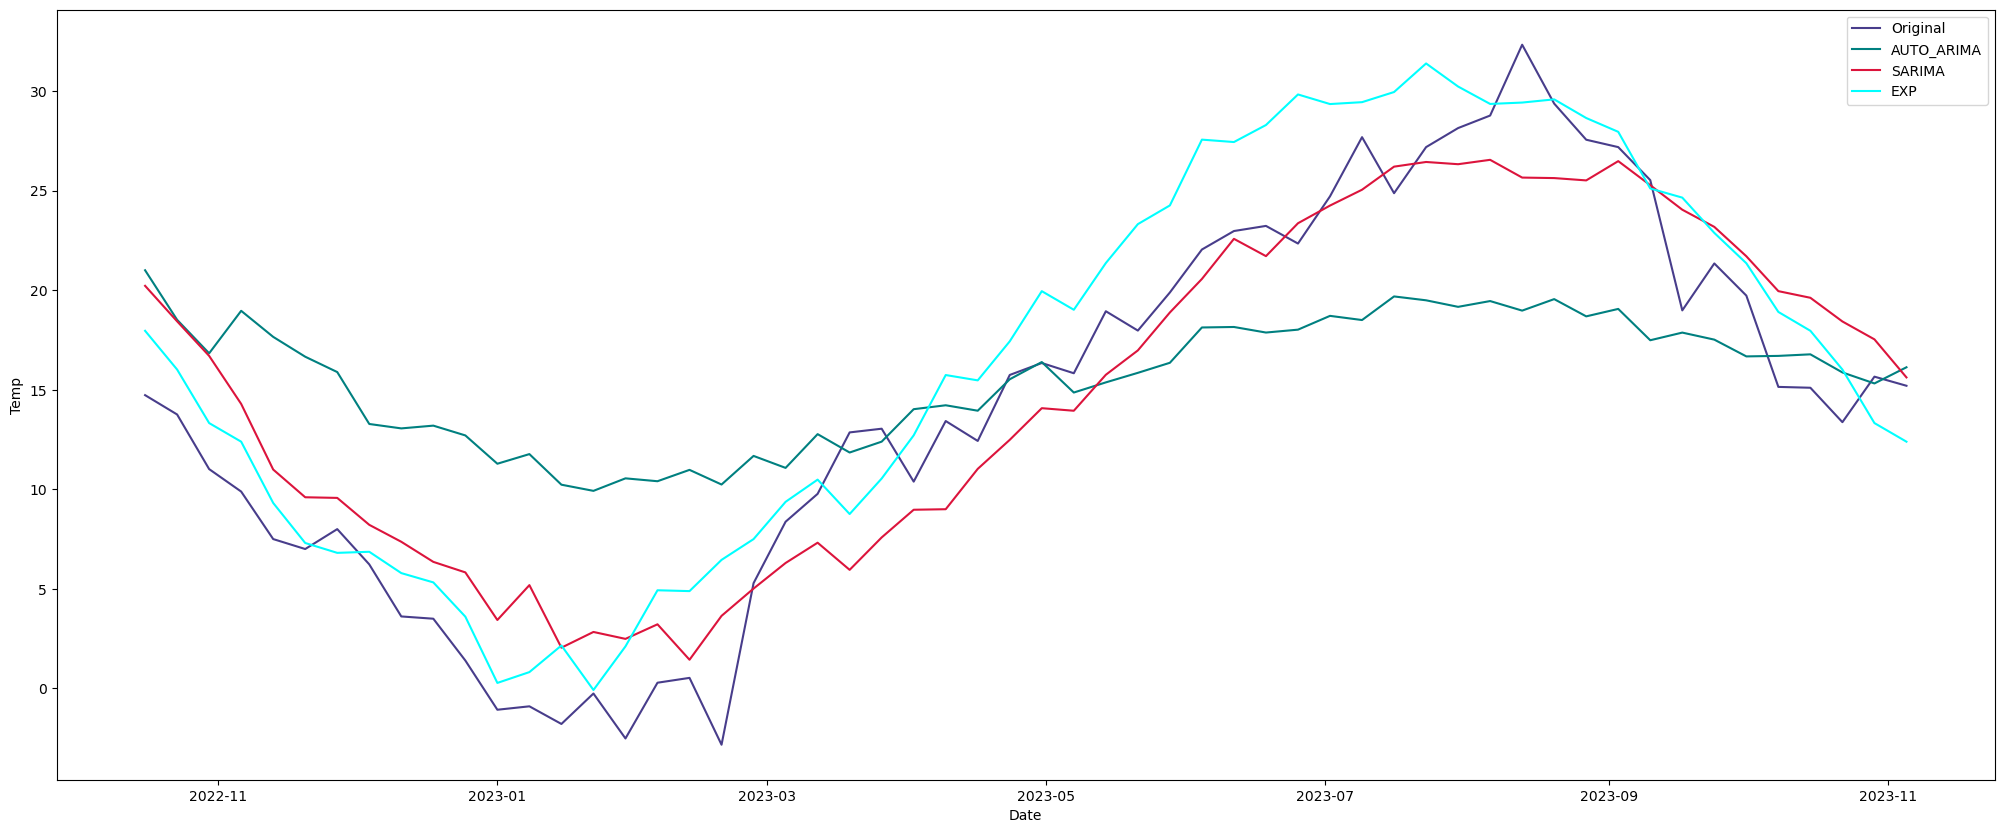

In [24]:
plt.figure(figsize = (25,10))
plt.plot(test_data.datetime, test_data.temp, color = 'DarkSlateBlue', label = 'Original')
plt.plot(test_data.datetime, auto_preds, color = 'Teal', label = 'AutoArima')
plt.plot(test_data.datetime, sarima_preds, color = 'Crimson', label = 'SARIMA')
plt.plot(test_data.datetime, exp_smoothing_preds, color = 'cyan', label = 'EXP')
plt.xlabel('Date')
plt.ylabel('Temp')
plt.legend(['Original', 'AUTO_ARIMA', 'SARIMA', "EXP"])
plt.show()

• Estimate best model for original data (100%), forecast with best model (choose forecast periods
that relevant for your research question), plot the data and forecast.

In [25]:
sarima_auto_mse = np.sqrt(mean_squared_error(test_data.temp, auto_preds))
sarima_mse = np.sqrt(mean_squared_error(test_data.temp, sarima_preds))
exp_mse = np.sqrt(mean_squared_error(test_data.temp, exp_smoothing_preds))
print("MSE for SARIMA test model is ", sarima_mse)
print("MSE for Auto SARIMA test model is ",sarima_auto_mse)
print("MSE for Exponential Smoothing test model is ",exp_mse)

MSE for SARIMA test model is  3.4437653065709366
MSE for Auto SARIMA test model is  7.317945824998889
MSE for Exponential Smoothing test model is  3.37500177650078


Holt Winter's model provides the best forecast for our data, so we will go ahead with it.

In [26]:
EXP = ExponentialSmoothing(df['temp'], trend=None, seasonal= 'add',seasonal_periods=52).fit()
forecast_steps = 5
exp_preds = EXP.forecast(steps=forecast_steps)

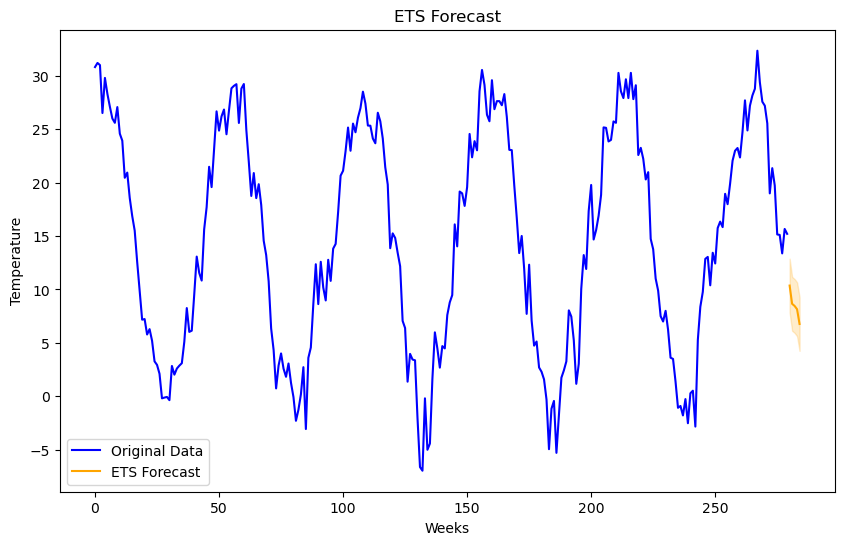

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['temp'], label='Original Data', color='blue')

# Plot ETS forecast
exp_preds = EXP.forecast(steps=forecast_steps)
exp_preds_ci = pd.DataFrame(index=exp_preds.index, data={'lower': exp_preds - 1.96 * exp_preds.std(), 'upper': exp_preds + 1.96 * exp_preds.std()})
plt.plot(exp_preds.index, exp_preds, label='ETS Forecast', color='orange')
plt.fill_between(exp_preds_ci.index, exp_preds_ci['lower'], exp_preds_ci['upper'], color='orange', alpha=0.2)

plt.xlabel('Weeks')
plt.ylabel('Temperature')
plt.title('ETS Forecast')
plt.legend()
plt.show()


## VAR


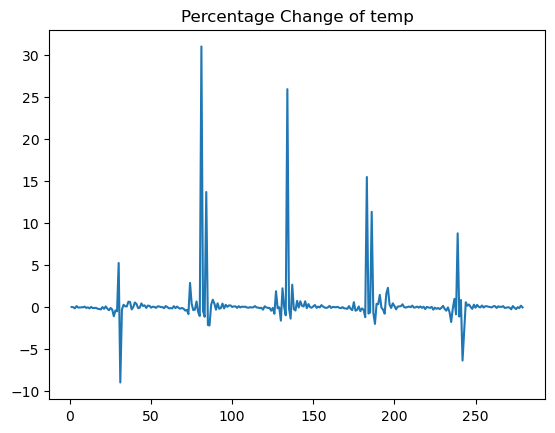


ADF Statistic for temp: -7.940511947448688
p-value for temp: 3.3236507044851218e-12
Critical Values:
	1%: -3.4542672521624214
	5%: -2.87206958769775
	10%: -2.5723807881747534
temp is likely stationary.


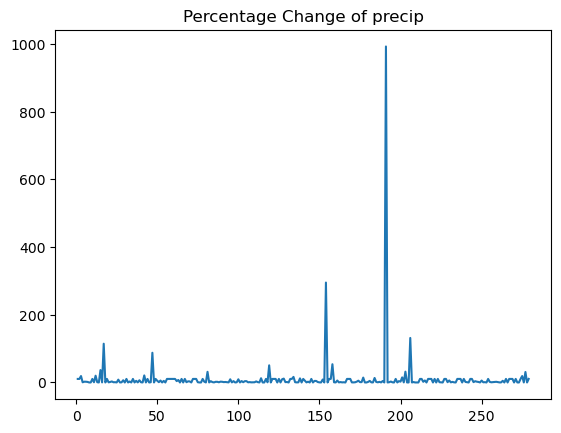


ADF Statistic for precip: -17.0078221095158
p-value for precip: 8.63491233540651e-30
Critical Values:
	1%: -3.4540935579190495
	5%: -2.8719934111688965
	10%: -2.5723401594120388
precip is likely stationary.


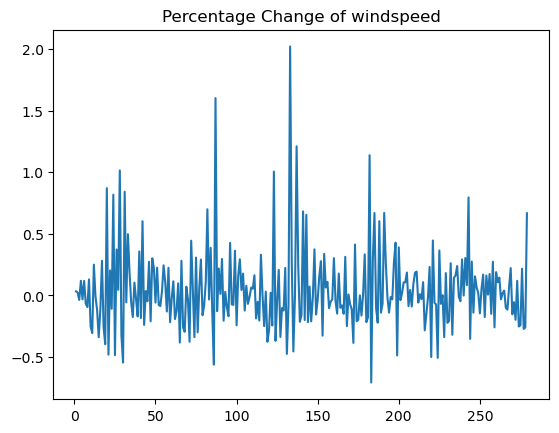


ADF Statistic for windspeed: -7.488017324903823
p-value for windspeed: 4.583933870365725e-11
Critical Values:
	1%: -3.454355055831705
	5%: -2.8721080938842976
	10%: -2.572401325619835
windspeed is likely stationary.


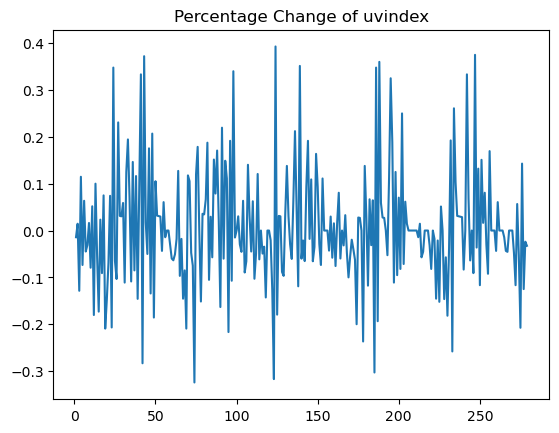


ADF Statistic for uvindex: -4.640005267632944
p-value for uvindex: 0.00010892773711252959
Critical Values:
	1%: -3.455365238788105
	5%: -2.8725510317187024
	10%: -2.5726375763314966
uvindex is likely stationary.


In [28]:
columns_to_concat = ['temp', 'precip', 'windspeed', 'uvindex']
df_new = pd.concat([df[column].pct_change().dropna() for column in columns_to_concat], axis=1)
df_new.columns = columns_to_concat
df_new.replace([np.inf, -np.inf], np.nan, inplace=True)
df_new.fillna(df_new.mean(), inplace=True)


for column in df_new.columns:
    plt.plot(df_new[column])
    plt.title(f'Percentage Change of {column}')
    plt.show()

    column_change = df_new[column].dropna()
    result = adfuller(column_change)
    
    print(f'\nADF Statistic for {column}: {result[0]}')
    print(f'p-value for {column}: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    
    if result[1] < 0.005:
        print(f'{column} is likely stationary.')
    else:
        print(f'{column} is not stationary.')


All features show seasonality patterns, but have no trend

### a. Select an appropriate VAR(p) model by using information criteria.

In [29]:
from statsmodels.tsa.api import VAR
model = VAR(df_new)
information_criteria = model.select_order(maxlags=24)
information_criteria.summary()

,AIC,BIC,FPE,HQIC
0,4.229,4.284*,68.64,4.251
1,4.050,4.327,57.38,4.161
2,3.991,4.491,54.11,4.192
3,3.871,4.593,47.99,4.161*
4,3.888,4.832,48.83,4.267
5,3.785*,4.951,44.08*,4.254
6,3.834,5.223,46.36,4.393
7,3.862,5.473,47.77,4.510
8,3.842,5.675,46.87,4.579
9,3.917,5.973,50.68,4.744


We will take the fifth lag, as the AIC value is the smallest

### b. Fit the selected model and interpret all coefficients.

In [30]:
model = VAR(df_new)
results = model.fit(5)  
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 17, Dec, 2023
Time:                     21:50:43
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    4.76693
Nobs:                     274.000    HQIC:                   4.10385
Log likelihood:          -1972.47    FPE:                    38.8792
AIC:                      3.65925    Det(Omega_mle):         28.9355
--------------------------------------------------------------------
Results for equation temp
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.243455         0.189265            1.286           0.198
L1.temp             -0.083804         0.062352           -1.344           0.179
L1.precip           -0.002749         0.002726           -1.008  

- Temperature residuals exhibit a subtle positive correlation with precipitation and a slight negative correlation with UV index, indicating that higher temperatures are associated with a modest increase in precipitation and a decrease in UV indices after accounting for lagged effects. 
- Precipitation residuals, on the other hand, show a mild positive correlation with windspeed, suggesting a modest association between increased precipitation and higher windspeed. 
- Windspeed residuals exhibit a weak positive correlation with temperature and a moderate positive correlation with UV index, implying that elevated windspeeds are linked to slightly higher temperatures and UV indices. 
- UV index residuals display a weak negative correlation with both temperature and precipitation, suggesting that higher UV indices are associated with lower temperatures and reduced precipitation.

In [31]:
endog_vars = model.endog

adf_results = pd.DataFrame(columns=['ADF Statistic', 'P-value', 'Critical Values'])

for i in range(endog_vars.shape[1]):
    variable = endog_vars[:, i]
    adf_result = adfuller(variable)
    adf_results.loc[i] = [adf_result[0], adf_result[1], adf_result[4]]

# Check if any P-values are less than 0.05
non_significant_variables = adf_results[adf_results['P-value'] > 0.05]
print(non_significant_variables)

Empty DataFrame
Columns: [ADF Statistic, P-value, Critical Values]
Index: []


Based on ADF test, all P-values are less than 0.05, so the time series is stationary.

### c. Examine the residuals. Comment.


In [32]:
residuals = results.resid
result_df = pd.DataFrame(columns=['lag', 'lb_pvalue'])
num_lags = 15

for column in df_new.columns:

    lb_test = sm.stats.acorr_ljungbox(residuals[column], lags=num_lags, return_df=True)
    a_df = pd.DataFrame({'lb_pvalue': lb_test['lb_pvalue']})
    a_df['lag'] = np.arange(1, len(a_df) + 1)

    result_df = pd.concat([result_df, a_df], ignore_index=True)

non_significant_results = result_df[result_df['lb_pvalue'] < 0.05]
print(non_significant_results)


Empty DataFrame
Columns: [lag, lb_pvalue]
Index: []


As we have empty df, we can conclude that all residuals were not iid. 

### d. Perform an impulse response analysis (i.e. plot the IRF and comment). Are the results sensible for you? 

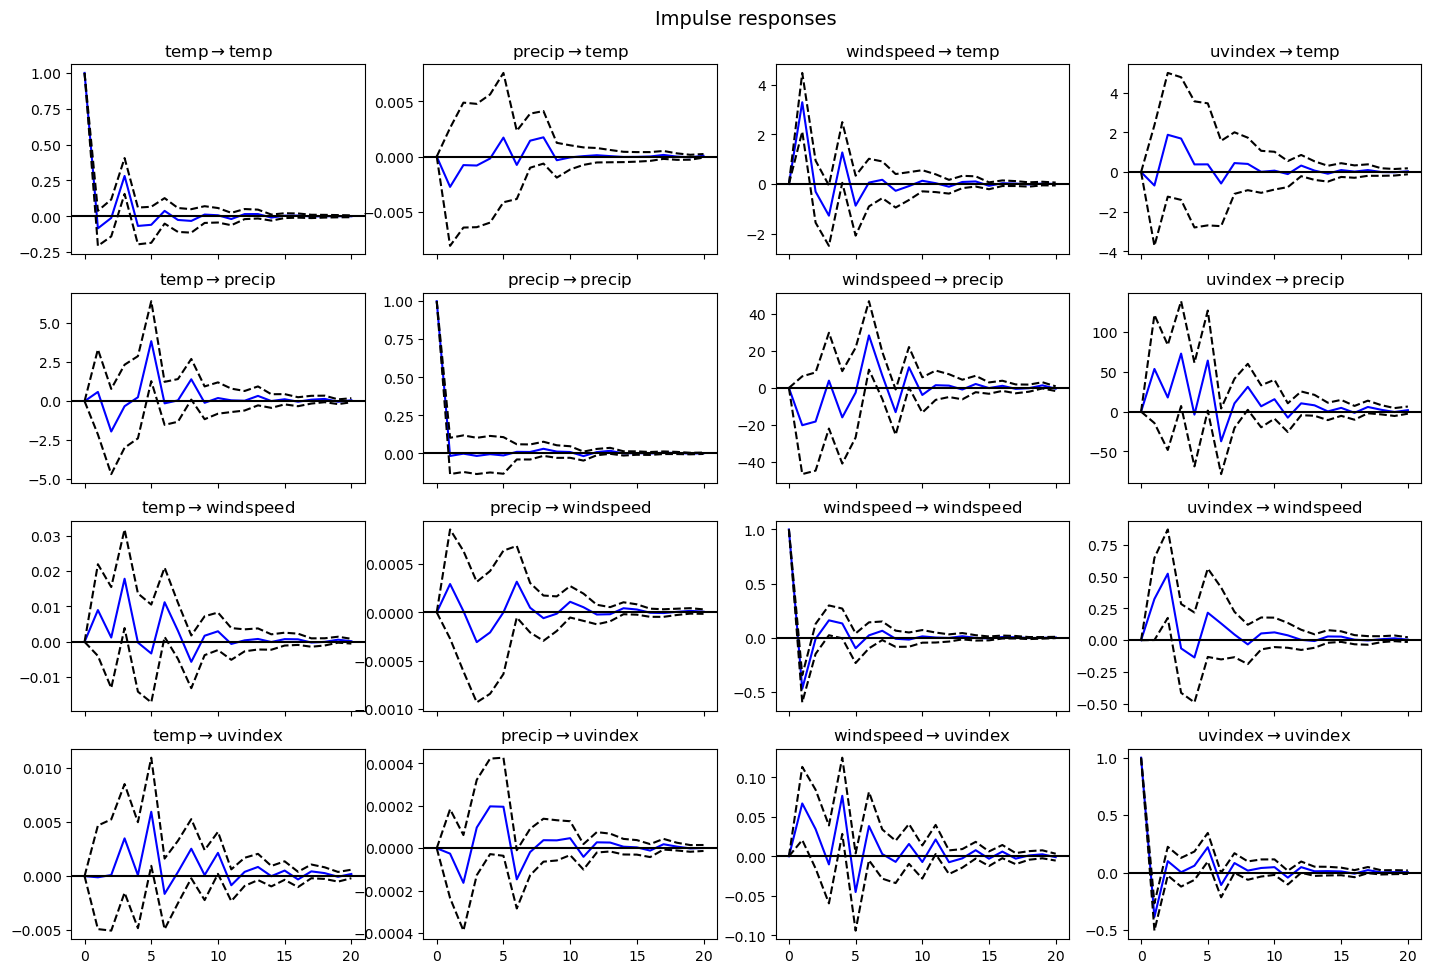

In [33]:
irf = results.irf(20)
irf.plot(orth=False,figsize = [15,10]);

After a positive shock to the corresponding column variable, the other variables increase, suggesting a positive relationship between them. Conversely, after a negative shock to the column variable, all variables decrease. 

- For temp, after lag 18 the shock effect is approaching 0.
- For precip, after lag 15 the shock effect is approaching 0.
- For windspeed, after lag 13 the shock effect is approaching to 0.
- For uvindex, after lag 20 the shock effect is approaching to 0.

### e. Produce up to 10 points ahead forecast.

In [34]:
forecast_steps = 5
forecast_values = results.forecast(y=df_new.values, steps=forecast_steps)
forecast_df = pd.DataFrame(forecast_values, columns=df_new.columns)
print(forecast_df)

       temp     precip  windspeed   uvindex
0  2.204873 -18.022768  -0.256531 -0.006739
1  0.408668   1.402847  -0.054342  0.042720
2 -0.391483   8.012364   0.096575 -0.056734
3  1.220734  -3.358046   0.139748  0.052210
4 -0.226167   1.128443  -0.044138 -0.037869


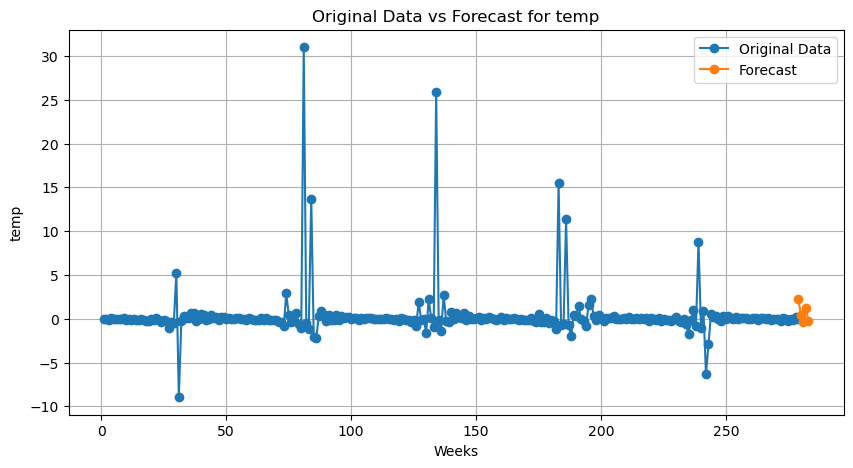

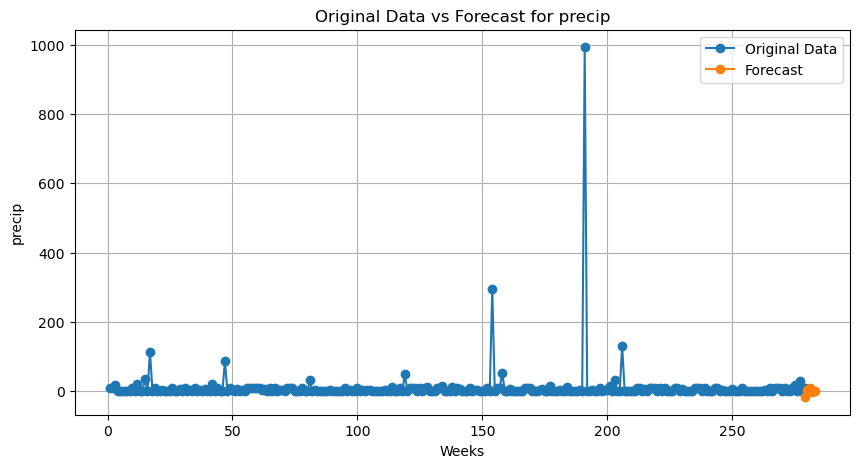

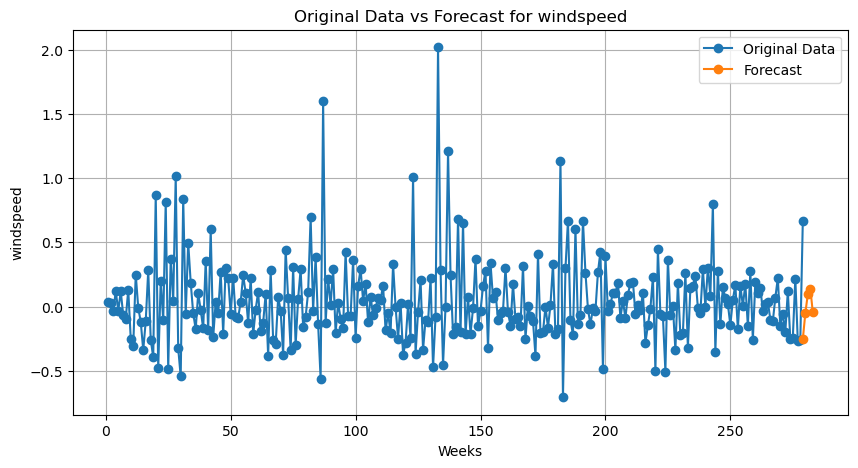

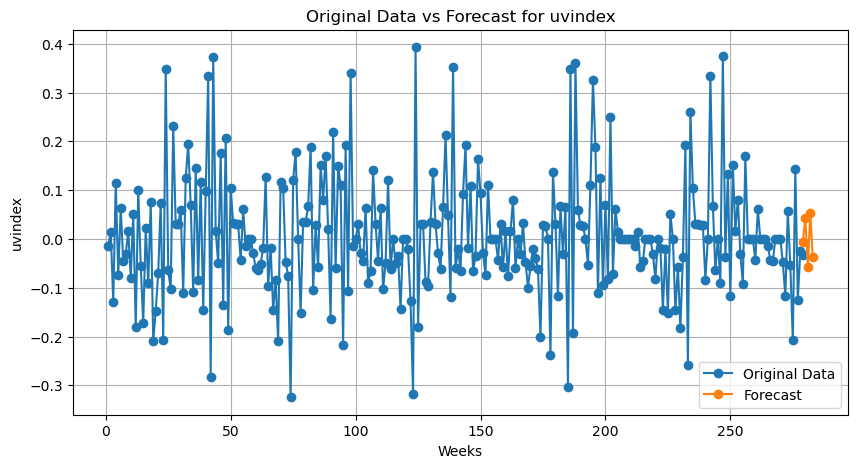

In [35]:
forecast_steps = forecast_df.shape[0]

# Plot each variable
for column in df_new.columns:
    plt.figure(figsize=(10, 5))
    plt.plot(df_new.index, df_new[column], label='Original Data', marker='o')
    plt.plot(range(len(df_new), len(df_new) + forecast_steps), forecast_df[column], label='Forecast', marker='o')
    plt.xlabel('Weeks')
    plt.ylabel(column)
    plt.title(f'Original Data vs Forecast for {column}')
    plt.legend()
    plt.grid(True)
    plt.show()
$

In [38]:
common_index = df_new.index.intersection(forecast_df.index)

# Compute MSE for each variable
mse_results = {}
for column in df_new.columns:
    mse = mean_squared_error(df_new.loc[common_index, column], forecast_df.loc[common_index, column])
    mse_results[column] = mse
    print(f'MSE for {column}: {mse}')

# Average MSE across variables
average_mse = sum(mse_results.values()) / len(mse_results)
print(f'Average MSE across variables: {average_mse}')


MSE for temp: 0.57310284536191
MSE for precip: 131.67388620822507
MSE for windspeed: 0.017676252074775706
MSE for uvindex: 0.01607458561480798
Average MSE across variables: 33.07018497281914
